In [2]:
import ipywidgets as widgets
model_no = widgets.Text(value='5.0')
epochs = widgets.IntSlider(value=300, min=0, max=10000, step=100)
print('Model number')
display(model_no)
print('Epochs')
display(epochs)

Model number


Text(value='5.0')

Epochs


IntSlider(value=300, max=10000, step=100)

##### CNN + GRU, 
##### Conservative Data augmentation methods - zoom , horizontal flip, rotation, (change zoom to 0.4., width shift range = 0.4, height_shift = 0.4 rotation range 12)
##### Change: holding out val files in a separate folder and shuffling training set

sequence generator shape (corrected) (b, n, w, h, c)

In [3]:
import os
import glob
import keras

In [4]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
import tensorflow as tf
import datetime

In [5]:
# from patrice's blogpost
from keras_video import VideoFrameGenerator

In [6]:
classes = ['suture_throws', 'hand_ties', 'thread_cuts']
classes.sort()
print(classes)

['hand_ties', 'suture_throws', 'thread_cuts']


In [7]:
# some global params
SIZE = (128, 128) # height and width of frame pxl by pxl
CHANNELS = 3 # RGB or whatever
NBFRAME = 5 # num frames in sequence 
BS = 8 # Batch size

In [8]:
# pattern to get videos and classes
glob_pattern='../../data_v4_model_5.0/model_data/{classname}/*.avi'

In [9]:
# # for data augmentation
# data_aug = keras.preprocessing.image.ImageDataGenerator(
#     zoom_range=.4,
#     horizontal_flip=True,
#     rotation_range=12,
#     width_shift_range=.4,
#     height_shift_range=.4)

In [10]:
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Total data: 3 classes for 792 files for train


In [11]:
# getting validation data
#valid = train.get_validation_generator()

val_glob_pattern = '../../data_v4_model_5.0/model_data/validataion_set/{classname}/*.avi'
# val_files = glob.glob(val_glob_pattern.format(classname='suture_throws'))
# print(val_files)
validation_data = glob.glob(val_glob_pattern.format(classname='hand_ties')) + glob.glob(val_glob_pattern.format(classname='suture_throws')) + glob.glob(val_glob_pattern.format(classname='thread_cuts'))
valid = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=val_glob_pattern,
    nb_frames=NBFRAME, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True,
    _validation_data=validation_data)

Total data: 3 classes for 315 files for validation


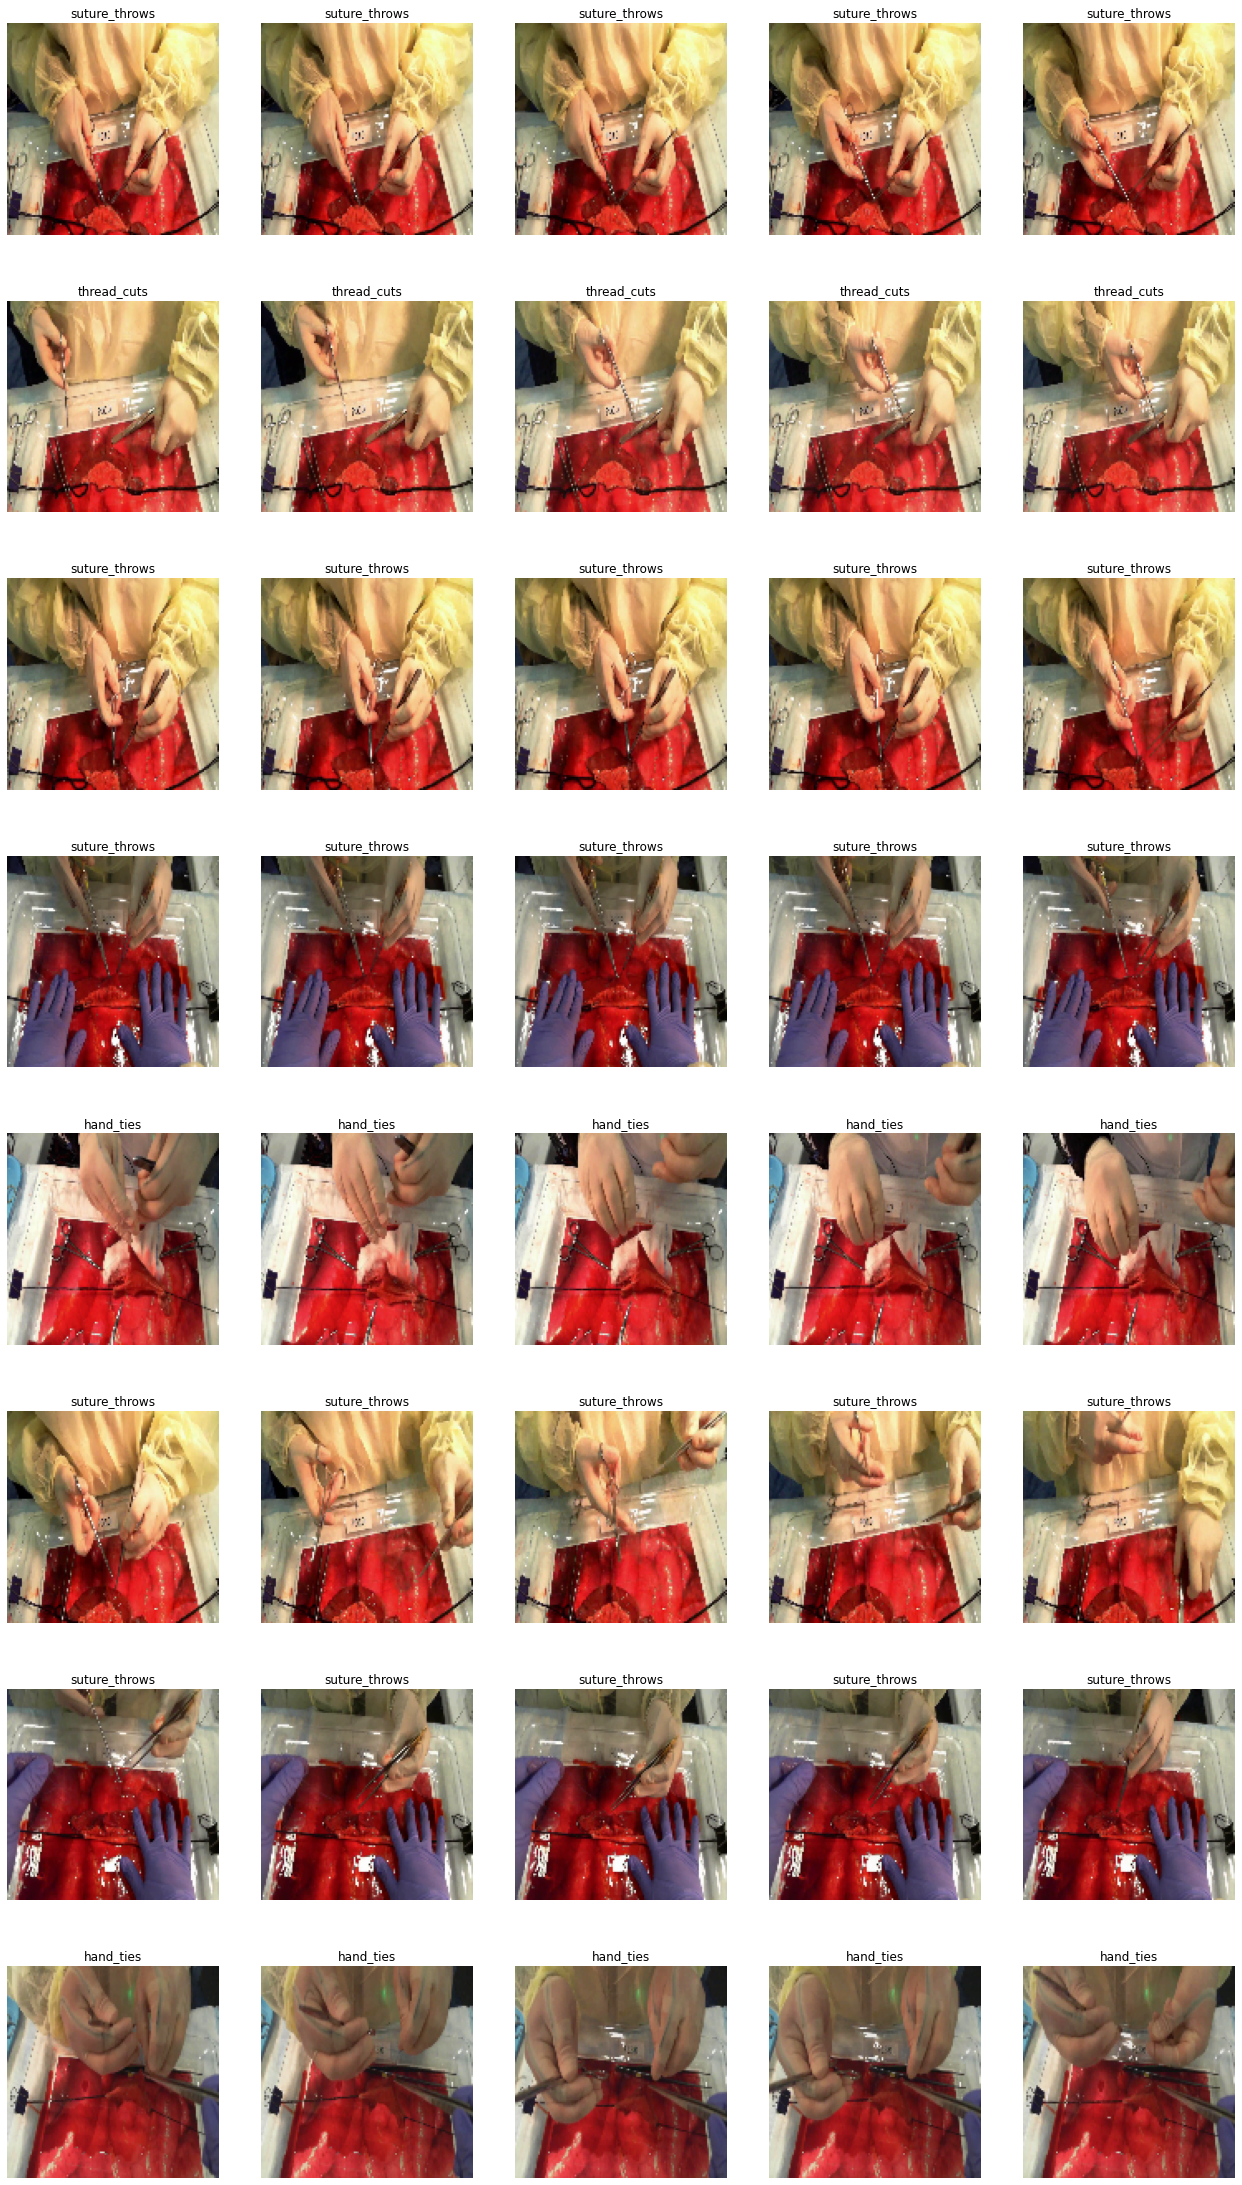

In [12]:
import keras_video.utils
keras_video.utils.show_sample(valid)

In [13]:
#valid.files

## BUILD CONV NET

In [14]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_mobilenet(shape=(224, 224, 3), nbout=3):
#     model = keras.applications.mobilenet.MobileNet(
#         include_top=False,
#         input_shape=shape,
#         weights='imagenet')
    
    model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        #input_tensor=None,
        input_shape=shape,
        pooling=None,
        classes=1000,
    )
    # Keep 9 layers to train﻿﻿
    trainable = 9
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
        
    # adding a max pool
    output = GlobalMaxPool2D()

    return keras.Sequential([model, output])

## Build GRU

In [15]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
# Shape (5, 112, 112, 3) 5 - time sequence length 112x112 = height vs width 3 - num channels
def action_model(shape=(5, 112, 112, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_mobilenet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    # KEY = allows you to add a time sequence to a layer one at a time
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

## this is where you tell the model how to train - loss function, weight update mechanism

In [16]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (20, 112, 112, 3)
# action model - GRU set up for Time shifted CNN
model = action_model(INSHAPE, len(classes))

# this is where you tell the model how to train - loss function, weight update mechanism
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

## epochs, call backs

In [17]:
log_dir = "logs/fit/model_{}_".format(model_no.value) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
print('logs for this run are here: {}'.format(log_dir))

logs for this run are here: logs/fit/model_5.0_20210618-161556


In [18]:
EPOCHS=epochs.value
print('number of epochs: {}'.format(epochs.value))
model_dir = './model_' + model_no.value + '_chkp/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    print('new folder created for new model: {}'.format(model_dir))
    
model_save_path = model_dir + 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'    

number of epochs: 300


In [19]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        model_save_path,
        verbose=1),
    tensorboard_callback
]

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/300
99/99 [==============================] - 312s 3s/step - loss: 1.1759 - acc: 0.3014 - val_loss: 1.1002 - val_acc: 0.3333

Epoch 00001: saving model to ./model_5.0_chkp\weights.01-1.10.hdf5
Epoch 2/300
99/99 [==============================] - 6s 56ms/step - loss: 1.1278 - acc: 0.3132 - val_loss: 1.1018 - val_acc: 0.3333

Epoch 00002: saving model to ./model_5.0_chkp\weights.02-1.10.hdf5
Epoch 3/300
99/99 [==============================] - 5s 49ms/step - loss: 1.1115 - acc: 0.3554 - val_loss: 1.0987 - val_acc: 0.3333

Epoch 00003: saving model to ./model_5.0_chkp\weights.03-1.10.hdf5
Epoch 4/300
99/99 [==============================] - 5s 49ms/step - loss: 1.1182 - acc: 0.2952 - val_loss: 1.0989 - val_acc: 0.3365

Epoch 00004: saving model to ./model_5.0_chkp\weights.04-1.10.hdf5
Epoch 5/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0995 - acc: 0.3448 - val_loss: 1.0988 - val_acc: 0.3333

Epoch 00005: saving model to ./model_5.0_chkp\weights.05-1.10.hdf5



Epoch 00040: saving model to ./model_5.0_chkp\weights.40-1.10.hdf5
Epoch 41/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0980 - acc: 0.3698 - val_loss: 1.0986 - val_acc: 0.3301

Epoch 00041: saving model to ./model_5.0_chkp\weights.41-1.10.hdf5
Epoch 42/300
99/99 [==============================] - 5s 50ms/step - loss: 1.0975 - acc: 0.3386 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00042: saving model to ./model_5.0_chkp\weights.42-1.10.hdf5
Epoch 43/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0986 - acc: 0.3501 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00043: saving model to ./model_5.0_chkp\weights.43-1.10.hdf5
Epoch 44/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0993 - acc: 0.3162 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00044: saving model to ./model_5.0_chkp\weights.44-1.10.hdf5
Epoch 45/300
99/99 [==============================] - 5s 50ms/step - loss: 1.0973 - acc: 0.4074 - val_loss: 1.0986 - val_acc: 0.

Epoch 80/300
99/99 [==============================] - 5s 48ms/step - loss: 1.0983 - acc: 0.3439 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00080: saving model to ./model_5.0_chkp\weights.80-1.10.hdf5
Epoch 81/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0985 - acc: 0.3697 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00081: saving model to ./model_5.0_chkp\weights.81-1.10.hdf5
Epoch 82/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0984 - acc: 0.3332 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00082: saving model to ./model_5.0_chkp\weights.82-1.10.hdf5
Epoch 83/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0991 - acc: 0.3145 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00083: saving model to ./model_5.0_chkp\weights.83-1.10.hdf5
Epoch 84/300
99/99 [==============================] - 5s 48ms/step - loss: 1.0998 - acc: 0.3167 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00084: saving model to ./model_5.0_chkp\weights.84-1.10.

Epoch 119/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0996 - acc: 0.3319 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00119: saving model to ./model_5.0_chkp\weights.119-1.10.hdf5
Epoch 120/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0995 - acc: 0.3115 - val_loss: 1.0987 - val_acc: 0.3301

Epoch 00120: saving model to ./model_5.0_chkp\weights.120-1.10.hdf5
Epoch 121/300
99/99 [==============================] - 5s 48ms/step - loss: 1.0989 - acc: 0.3459 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00121: saving model to ./model_5.0_chkp\weights.121-1.10.hdf5
Epoch 122/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0990 - acc: 0.3255 - val_loss: 1.0986 - val_acc: 0.3365

Epoch 00122: saving model to ./model_5.0_chkp\weights.122-1.10.hdf5
Epoch 123/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0980 - acc: 0.3285 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00123: saving model to ./model_5.0_chkp\weights

Epoch 158/300
99/99 [==============================] - 5s 48ms/step - loss: 1.0976 - acc: 0.3750 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00158: saving model to ./model_5.0_chkp\weights.158-1.10.hdf5
Epoch 159/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0995 - acc: 0.2931 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00159: saving model to ./model_5.0_chkp\weights.159-1.10.hdf5
Epoch 160/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0991 - acc: 0.3220 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00160: saving model to ./model_5.0_chkp\weights.160-1.10.hdf5
Epoch 161/300
99/99 [==============================] - 5s 48ms/step - loss: 1.0990 - acc: 0.3359 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00161: saving model to ./model_5.0_chkp\weights.161-1.10.hdf5
Epoch 162/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0986 - acc: 0.3472 - val_loss: 1.0986 - val_acc: 0.3365

Epoch 00162: saving model to ./model_5.0_chkp\weights

Epoch 197/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0984 - acc: 0.3563 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00197: saving model to ./model_5.0_chkp\weights.197-1.10.hdf5
Epoch 198/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0987 - acc: 0.3286 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00198: saving model to ./model_5.0_chkp\weights.198-1.10.hdf5
Epoch 199/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0989 - acc: 0.3016 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00199: saving model to ./model_5.0_chkp\weights.199-1.10.hdf5
Epoch 200/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0993 - acc: 0.2734 - val_loss: 1.0986 - val_acc: 0.3365

Epoch 00200: saving model to ./model_5.0_chkp\weights.200-1.10.hdf5
Epoch 201/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0984 - acc: 0.3623 - val_loss: 1.0986 - val_acc: 0.3365

Epoch 00201: saving model to ./model_5.0_chkp\weights

Epoch 236/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0985 - acc: 0.3090 - val_loss: 1.0987 - val_acc: 0.3301

Epoch 00236: saving model to ./model_5.0_chkp\weights.236-1.10.hdf5
Epoch 237/300
99/99 [==============================] - 5s 48ms/step - loss: 1.0993 - acc: 0.3048 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00237: saving model to ./model_5.0_chkp\weights.237-1.10.hdf5
Epoch 238/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0977 - acc: 0.3319 - val_loss: 1.0987 - val_acc: 0.3301

Epoch 00238: saving model to ./model_5.0_chkp\weights.238-1.10.hdf5
Epoch 239/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0980 - acc: 0.3275 - val_loss: 1.0986 - val_acc: 0.3365

Epoch 00239: saving model to ./model_5.0_chkp\weights.239-1.10.hdf5
Epoch 240/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0996 - acc: 0.3087 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00240: saving model to ./model_5.0_chkp\weights

99/99 [==============================] - 5s 48ms/step - loss: 1.0981 - acc: 0.3677 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00275: ReduceLROnPlateau reducing learning rate to 1.0000001536343539e-30.

Epoch 00275: saving model to ./model_5.0_chkp\weights.275-1.10.hdf5
Epoch 276/300
99/99 [==============================] - 5s 48ms/step - loss: 1.0983 - acc: 0.3378 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00276: saving model to ./model_5.0_chkp\weights.276-1.10.hdf5
Epoch 277/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0988 - acc: 0.3176 - val_loss: 1.0986 - val_acc: 0.3365

Epoch 00277: saving model to ./model_5.0_chkp\weights.277-1.10.hdf5
Epoch 278/300
99/99 [==============================] - 5s 49ms/step - loss: 1.0987 - acc: 0.2993 - val_loss: 1.0986 - val_acc: 0.3365

Epoch 00278: saving model to ./model_5.0_chkp\weights.278-1.10.hdf5
Epoch 279/300
99/99 [==============================] - 5s 48ms/step - loss: 1.0982 - acc: 0.3809 - val_loss: 1.0986 - va